In [1]:
# Understanding autoencoders via a another example---> simple solid boxes in an image 
# This time I want to apply variational autoencoder (VAE )

In [1]:
# written by the help of this:
# https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

In [2]:


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

/home/sobhan/miniconda3/envs/ml-dl/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
from math import sqrt

def box(radius=2, box_size=28):
    '''
    to put some solid boxes in plain white images
    returns image(s) with boxes on them with the radius defined for them
    Comment: radius is a misnormer here. I wanted to show a scale thing for box in image
    firstly I wrote a cricle function (not a box) that is why I left radius like this 
    '''
    
    if isinstance(radius, int):
        rads = np.array([radius])
    elif not isinstance(radius, np.ndarray):
        rads = np.array(radius)
        
    rads = np.array(radius)

    position = np.zeros((rads.size, box_size//2 * 2, box_size//2 * 2))
    for i, r in enumerate(rads):
        
        for  x in range(-box_size//2, box_size//2):
            for y in range(-box_size//2, box_size//2):
                if ((abs(x) - r) < 0.01 and (abs(y) - r) < 0.01 ):
                    position[i, x+box_size//2 , y+box_size//2] = 1
   
    return  torch.from_numpy(position).flatten(start_dim=1)
    

In [4]:
box_siz = 24
num_samples = 1000   # sample data number
rand_radious= torch.randint(3, 150, (num_samples,))/10 # create a random array of raduis
features = box(radius=rand_radious, box_size=box_siz)  # data set

In [5]:
features.shape

torch.Size([1000, 576])

In [6]:
batch_size = 40
# img_size = (32, 32) # (width, height)
# x_dim  = 784
# x_dim  = 784

input_dim = (box_siz//2 * 2)**2
hidden_dim = 400
latent_dim = 20


# input_dim = 3
# hidden_dim = 128
# n_embeddings= 768
output_dim = input_dim

lr = 2e-4

epochs = 300
DEVICE = 'cpu'
print_step = 50

In [7]:
from torch.utils import data

def load_array(data_arrays, batch_size, is_train=True): #@save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [8]:
train_x = features[:-20]
test_x  = features[-20:]

train_loader = load_array((train_x, train_x), batch_size)
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = load_array((test_x, test_x), 10)

In [9]:
train_x.shape, test_x.shape

(torch.Size([980, 576]), torch.Size([20, 576]))

In [10]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [11]:

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [12]:
# This took me a while to understand it.
# z[i]= mu[i]+eps[i]*std[i]   for decoder 
# see bellow:

![image](VAE.jpg)

In [14]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var




In [15]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = output_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)


In [16]:
# model(features[0].float())

# Defining loss function

In [17]:


from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat.float(), x.float(), reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)



# Training

In [18]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
#         x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x.float())
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")


Start training VAE...
	Epoch 1 complete! 	Average Loss:  390.58460795084636
	Epoch 2 complete! 	Average Loss:  248.53755009969075
	Epoch 3 complete! 	Average Loss:  107.22409362792969
	Epoch 4 complete! 	Average Loss:  70.99181098937989
	Epoch 5 complete! 	Average Loss:  56.212481053670246
	Epoch 6 complete! 	Average Loss:  45.619019444783525
	Epoch 7 complete! 	Average Loss:  41.46055323282878
	Epoch 8 complete! 	Average Loss:  38.14867312113444
	Epoch 9 complete! 	Average Loss:  35.78027057647705
	Epoch 10 complete! 	Average Loss:  32.842362594604495
	Epoch 11 complete! 	Average Loss:  30.520989227294923
	Epoch 12 complete! 	Average Loss:  29.196020317077636
	Epoch 13 complete! 	Average Loss:  27.977867126464844
	Epoch 14 complete! 	Average Loss:  27.877230389912924
	Epoch 15 complete! 	Average Loss:  25.936965465545654
	Epoch 16 complete! 	Average Loss:  24.822387631734212
	Epoch 17 complete! 	Average Loss:  25.15625718434652
	Epoch 18 complete! 	Average Loss:  22.891132831573486
	E

In [19]:
import matplotlib.pyplot as plt
import numpy as np

In [20]:

sample_example = 5
x = features[sample_example].reshape(box_siz//2 *2,box_siz//2 *2).float()
y, mu, var = model(features[sample_example].float())
# y = mu + y*var
y = y.reshape(box_siz//2 *2,box_siz//2 *2).float()

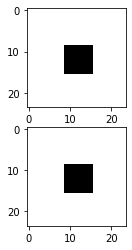

In [21]:
plt.subplot(211)
plt.imshow(x.detach().numpy(), cmap='Greys')
plt.subplot(212)
plt.imshow(y.detach().numpy(), cmap='Greys',  interpolation='nearest')

# Generate new samples

In [22]:
# now taking decoder we can produce new data samples

In [23]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_sample = decoder(noise)

In [24]:
generated_sample

tensor([[6.4448e-07, 5.4139e-07, 9.3890e-07,  ..., 2.7061e-03, 2.0500e-03,
         2.4460e-03],
        [8.9692e-01, 9.1562e-01, 9.0832e-01,  ..., 9.8773e-01, 9.8902e-01,
         9.8606e-01],
        [8.3196e-04, 9.0354e-04, 8.9273e-04,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        ...,
        [7.8035e-06, 7.7178e-06, 1.1643e-05,  ..., 7.0637e-02, 4.1615e-02,
         7.7021e-02],
        [2.4641e-25, 4.6598e-25, 1.4240e-24,  ..., 2.3447e-24, 7.7154e-25,
         2.5312e-23],
        [1.1093e-08, 6.4591e-09, 9.7673e-09,  ..., 1.5216e-07, 6.7318e-08,
         1.7078e-07]])

In [25]:
generated_sample[0].shape

torch.Size([576])

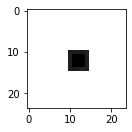

In [26]:
plt.subplot(212)
y = generated_sample[17].reshape(box_siz//2 *2,box_siz//2 *2).float()
plt.imshow(y.detach().numpy(), cmap='Greys',  interpolation='nearest')

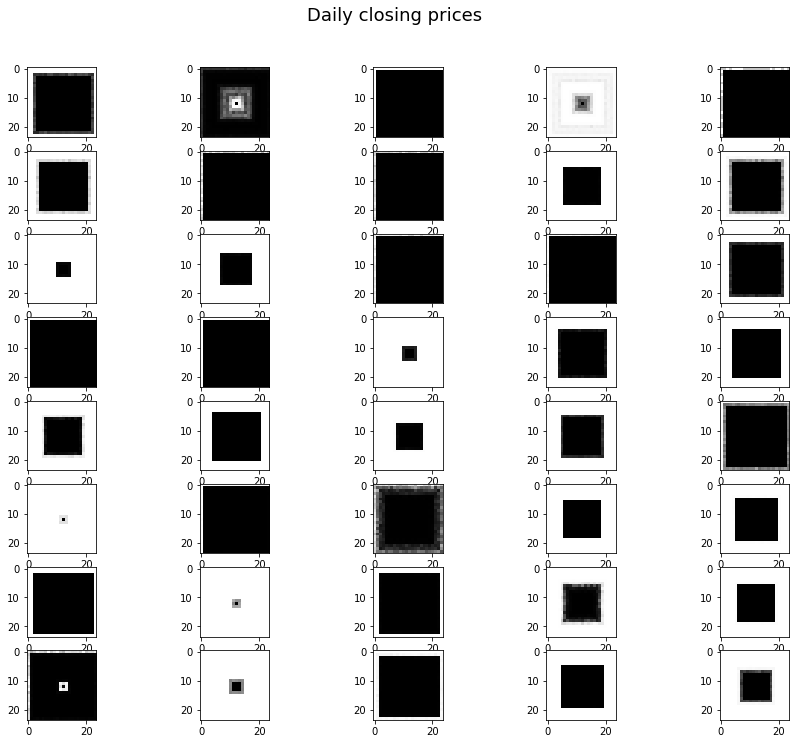

In [27]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Daily closing prices", fontsize=18, y=0.95)

# set number of columns (use 3 to demonstrate the change)
ncols =5
# calculate number of rows
nrows =batch_size//ncols
for idx, sample in enumerate (generated_sample):

    ax = plt.subplot(nrows, ncols, idx + 1)
    y = sample.reshape(box_siz//2 *2,box_siz//2 *2).float()

    plt.imshow(y.detach().numpy(), cmap='Greys',  interpolation='nearest')


# comment

In [28]:
#  Based on what the programmer said in: 
#     https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb



Please note that this is not the correct generative process.

    Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

    To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

